## Infection Path Analysis Using Routes

The purpose of this notebook is to try and analyse the path of infection for COVID-19. Below is a brief description of how the algorithm works.

### Path of Infection Algorithm

1. Pick a sufficiently large threshold (infected_thresh) which indicates when a location has been infected.
2. Using time series data, add the location that first recorded infections (even if it is below the threshold).
3. If a location becomes infected and has a direct path to another location that is infected then add an edge. If it does not have a direct path to another infected location then decrease infected_thresh and go back to step 2.
4. Repeat step 3 for all the time series data. If all infected locations are added and the rule defined in step 3 is never broken and the graph contains x% of the countries that have recorded COVID-19 

In [5]:
from covid_data import CovidData

covid_data_manager = CovidData()

covid_data, routes = covid_data_manager.getData(bin_region_column='country')
data_confirmed = covid_data['confirmed']
data_confirmed

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20
0,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,...,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,...,736,750,766,773,782,789,795,803,820,832
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,...,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,...,743,743,743,745,745,747,748,750,751,751
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,...,27,27,27,27,30,35,35,35,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,...,342,343,344,344,353,353,353,362,371,374
183,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
184,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,...,1,1,6,6,7,10,10,12,22,25
185,Zambia,-15.416700,28.283300,0,0,0,0,0,0,0,...,88,95,97,106,109,119,124,137,138,146


In [27]:
def clean_data(data_confirmed):
    return data_confirmed.loc[(data_confirmed['Lat'] != 0) & (data_confirmed['Long'] != 0)]
data_confirmed = clean_data(data_confirmed)

In [143]:
import networkx as nx

def get_initial_infect_thresh(data_confirmed, infect_percent):
    latest_date = data_confirmed.columns.tolist()[-1]
    num_of_countries = data_confirmed.shape[0]
    return data_confirmed.sort_values(latest_date).iloc[int(num_of_countries*(1-infect_percent))][latest_date]

def get_initial_case(data_confirmed, dates):
    first_date = dates[0]
    return data_confirmed.sort_values(first_date).iloc[-1]
    

def get_infection_path(data_confirmed, routes, infect_thresh, dates=dates):
    infect_graph = nx.Graph()
    dates = data_confirmed.columns.tolist()[3:]
    case_zero = get_initial_case(data_confirmed, dates)
    infect_graph.add_node(case_zero['Country/Region'])
    location_pos = {case_zero['Country/Region'] : (case_zero['Lat'], case_zero['Long'])}
    infect_graphs = {}
    max_confirmed = {}

    for date in dates:
        conf_sort_day =  data_confirmed.sort_values(date).loc[data_confirmed[date] >= infect_thresh]
        try:
            max_confirmed[date] = conf_sort_day.iloc[-1][date]
        except:
            max_confirmed[date] = case_zero[date]
        for _index, row in conf_sort_day.iterrows():
            country = row['Country/Region']
            if not infect_graph.has_node(country):
                already_infected = infect_graph.nodes
                coords = (row['Lat'], row['Long'])
                infect_graph.add_node(country, pos=coords)
                location_pos[country] = coords
                connect_to_infect = False
                for infected in already_infected:
                    if routes.loc[(routes['DepartCountry/Region'] == infected) & (routes['ArrivalCountry/Region'] == country)].shape[0] != 0 or routes.loc[(routes['ArrivalCountry/Region'] == infected) & (routes['DepartCountry/Region'] == country)].shape[0] != 0:
                        infect_graph.add_edge(infected, country)
                
        infect_graphs[date] = infect_graph.copy()
        
    return infect_graphs, location_pos, max_confirmed
                    

infect_thresh = get_initial_infect_thresh(data_confirmed, 0.95)
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs, location_pos, max_confirmed = get_infection_path(data_confirmed, routes, infect_thresh)

INITIAL INFECTION THRESHOLD SET TO 15


In [144]:
max_confirmed

{'1/22/20': 548,
 '1/23/20': 643,
 '1/24/20': 920,
 '1/25/20': 1406,
 '1/26/20': 2075,
 '1/27/20': 2877,
 '1/28/20': 5509,
 '1/29/20': 6087,
 '1/30/20': 8141,
 '1/31/20': 9802,
 '2/1/20': 11891,
 '2/2/20': 16630,
 '2/3/20': 19716,
 '2/4/20': 23707,
 '2/5/20': 27440,
 '2/6/20': 30587,
 '2/7/20': 34110,
 '2/8/20': 36814,
 '2/9/20': 39829,
 '2/10/20': 42354,
 '2/11/20': 44386,
 '2/12/20': 44759,
 '2/13/20': 59895,
 '2/14/20': 66358,
 '2/15/20': 68413,
 '2/16/20': 70513,
 '2/17/20': 72434,
 '2/18/20': 74211,
 '2/19/20': 74619,
 '2/20/20': 75077,
 '2/21/20': 75550,
 '2/22/20': 77001,
 '2/23/20': 77022,
 '2/24/20': 77241,
 '2/25/20': 77754,
 '2/26/20': 78166,
 '2/27/20': 78600,
 '2/28/20': 78928,
 '2/29/20': 79356,
 '3/1/20': 79932,
 '3/2/20': 80136,
 '3/3/20': 80261,
 '3/4/20': 80386,
 '3/5/20': 80537,
 '3/6/20': 80690,
 '3/7/20': 80770,
 '3/8/20': 80823,
 '3/9/20': 80860,
 '3/10/20': 80887,
 '3/11/20': 80921,
 '3/12/20': 80932,
 '3/13/20': 80945,
 '3/14/20': 80977,
 '3/15/20': 81003,
 '3/1

In [145]:
import sys
!{sys.executable} -m pip install ipyleaflet
!{sys.executable} -m pip install ipywidgets

In [146]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [147]:
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles, Circle, 
    Marker, FullScreenControl, LayersControl, 
    LayerGroup, CircleMarker, Polyline
)

In [148]:
def generate_graph(infect_graphs, location_pos, max_confirmed, data_confirmed, pymap, date, scale=1000000):
    infect_graph = infect_graphs[date]
    max_confirm = max_confirmed[date]
    
    marker_layer = LayerGroup(name='markers')
    circle_layer = LayerGroup(name='circles')
    
    for country in infect_graph.nodes:
        marker = Marker(location=location_pos[country], draggable=False, title=country, opacity=0)
        marker_layer.add_layer(marker)
        
        circle = Circle(location=location_pos[country], 
                        radius=int(data_confirmed.loc[data_confirmed['Country/Region'] == country][date]/max_confirm*scale),
                        color = 'red', fill_color = 'red')
        circle_layer.add_layer(circle)
    
    pymap.add_layer(marker_layer)
    pymap.add_layer(circle_layer)
    
def generate_routes(infect_graphs, location_pos, routes_df, pymap, date):
    infect_graph = infect_graphs[date]
    routes = routes_df[routes_df['ArrivalCountry/Region'] != routes_df['DepartCountry/Region']]
    max_route = max(routes['NumberOfRoutes'])
    line_layer = LayerGroup(name='Lines')
    
    for c1, c2 in infect_graph.edges:
        try:
            c1_to_c2 = routes.loc[(routes['DepartCountry/Region'] ==  c1) & (routes['ArrivalCountry/Region'] == c2)]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[(routes['ArrivalCountry/Region'] ==  c1) & (routes['DepartCountry/Region'] == c2)]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
        line = Polyline(locations=[location_pos[c1], location_pos[c2]], color='blue', opacity=routes_between/max_route)
        line_layer.add_layer(line)
        
    pymap.add_layer(line_layer)

In [151]:
DATE = '5/6/20'

infection_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(0,0), zoom=1)
infection_map.add_control(FullScreenControl())
generate_graph(infect_graphs, location_pos, max_confirmed, data_confirmed, infection_map, DATE)
generate_routes(infect_graphs, location_pos, routes, infection_map, DATE)
infection_map.add_control(LayersControl())

In [152]:
infection_map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HIGH AVERAGE BETWEEN COUNTRIES China AND US IS 652328.0
HIGH AVERAGE BETWEEN COUNTRIES Japan AND US IS 617969.5
HIGH AVERAGE BETWEEN COUNTRIES Thailand AND US IS 611837.5
HIGH AVERAGE BETWEEN COUNTRIES Singapore AND US IS 620442.0
HIGH AVERAGE BETWEEN COUNTRIES Korea, South AND US IS 615748.0
HIGH AVERAGE BETWEEN COUNTRIES Taiwan* AND US IS 610562.5
HIGH AVERAGE BETWEEN COUNTRIES Australia AND US IS 613790.0
HIGH AVERAGE BETWEEN COUNTRIES Vietnam AND US IS 610478.5
HIGH AVERAGE BETWEEN COUNTRIES Germany AND US IS 694424.0
HIGHEST AVERAGE BETWEEN COUNTRIES US AND US IS 1220686.0
HIGH AVERAGE BETWEEN COUNTRIES US AND Iran IS 661168.0
HIGH AVERAGE BETWEEN COUNTRIES US AND Italy IS 717571.5
HIGH AVERAGE BETWEEN COUNTRIES US AND Bahrain IS 612310.0
HIGH AVERAGE BETWEEN COUNTRIES US AND France IS 697455.0
HIGH AVERAGE BETWEEN COUNTRIES US AND Kuwait IS 613487.5
HIGH AVERAGE BETWEEN COUNTRIES US AND Spain IS 720505.5
HIGH AVERAGE BETWEEN COUNTRIES US AND United Kingdom IS 711522.5
HIGH AVERAG

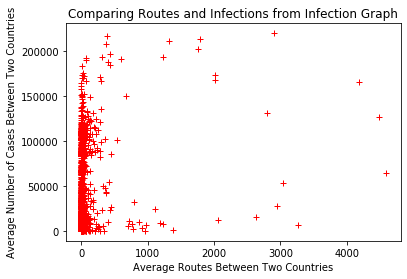

In [170]:
import matplotlib.pyplot as plt
def plot_latest_routes_to_cases(infect_graphs, routes, data_confirmed):
    latest_date = data_confirmed.columns[-1]
    infect_graph = infect_graphs[latest_date]
    
    avg_routes_between = []
    avg_cases_between = []
    for c1, c2 in infect_graph.edges:
        try:
            c1_to_c2 = routes.loc[(routes['DepartCountry/Region'] ==  c1) & (routes['ArrivalCountry/Region'] == c2)]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[(routes['ArrivalCountry/Region'] ==  c1) & (routes['DepartCountry/Region'] == c2)]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        
        avg_r_between = (c1_to_c2 + c2_to_c1)/2
        c1_cases = data_confirmed.loc[data_confirmed['Country/Region'] == c1][latest_date].tolist()[0]
        c2_cases = data_confirmed.loc[data_confirmed['Country/Region'] == c2][latest_date].tolist()[0]
        avg_cases = (c1_cases + c2_cases)/2
        if avg_cases > 1000000:
            print("HIGHEST AVERAGE BETWEEN COUNTRIES {} AND {} IS {}".format(c1, c2, avg_cases))
            continue
        if avg_cases > 500000:
            print("HIGH AVERAGE BETWEEN COUNTRIES {} AND {} IS {}".format(c1, c2, avg_cases))
            continue
        
        avg_routes_between.append(avg_r_between)
        avg_cases_between.append(avg_cases)
        
    plt.plot(avg_routes_between, avg_cases_between, 'r+')
    plt.title("Comparing Routes and Infections from Infection Graph")
    plt.xlabel("Average Routes Between Two Countries")
    plt.ylabel("Average Number of Cases Between Two Countries")
        
plot_latest_routes_to_cases(infect_graphs, routes, data_confirmed)